In [756]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from datetime import datetime, timedelta




Importacion de los Grandes Premios

In [757]:
df = pd.read_excel('gp.xlsx')
df.head()


,gp,x,y,fecha
0,Bahrein,50,26,2023-03-05
1,Arabia Saudi,39,21,2023-03-19
2,Autralia,144,-37,2023-04-02
3,Azerbaiyan,49,40,2023-04-30
4,Miami,-80,25,2023-05-07


funciones utilitarias para .xlsx

In [758]:
def to_xlsx(df_nodos, archivo_salida):

    datos = {
        'gp': [nodo.gp for nodo in df_nodos.iloc[:, 0]],
        'x': [nodo.x for nodo in df_nodos.iloc[:, 0]],
        'y': [nodo.y for nodo in df_nodos.iloc[:, 0]],
        'fecha': [(nodo.fecha.replace(year=2024) - timedelta(days=2)).date() for nodo in df_nodos.iloc[:, 0]] #actualizacion a 2024 con 2 dias de diferencia
    }

    
    df_transformado = pd.DataFrame(datos)
    df_transformado.to_excel(archivo_salida, index=False)

    print("archivo guardado: ", archivo_salida)


def distancia(x1, x2, y1, y2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2) * 100



def calcular_distancia_total(df):
    dist = 0
    for i in range(len(df)):
        if i + 1 >= len(df):
            break
        dist += distancia(df['x'].iloc[i], df['x'].iloc[i + 1], df['y'].iloc[i], df['y'].iloc[i + 1])
    return dist



def plot_gp(df,figsize=(30, 20)):

    plt.figure(figsize=figsize)
    plt.plot(df['x'], df['y'], marker='o', linestyle='--')

    initial_city = 0
    final_city = len(df) - 1

    for i, txt in enumerate(df['gp']):
        if i == initial_city:
            color = 'green'
        elif i == final_city:
            color = 'red'
        else:
            color = 'black'
        plt.annotate(txt, (df['x'][i], df['y'][i]), textcoords='offset points', xytext=(0, 2), ha='center', fontsize=12, color=color)

    plt.show()

Ruta actual

In [759]:
df.head(23)

,gp,x,y,fecha
0,Bahrein,50,26,2023-03-05
1,Arabia Saudi,39,21,2023-03-19
2,Autralia,144,-37,2023-04-02
3,Azerbaiyan,49,40,2023-04-30
4,Miami,-80,25,2023-05-07
5,Emilia Romaña,11,44,2023-05-21
6,Monaco,7,43,2023-05-28
7,España,2,41,2023-06-04
8,Canada,-73,45,2023-06-18
9,Austria,14,47,2023-07-02


distancia total:  143340.83859405687


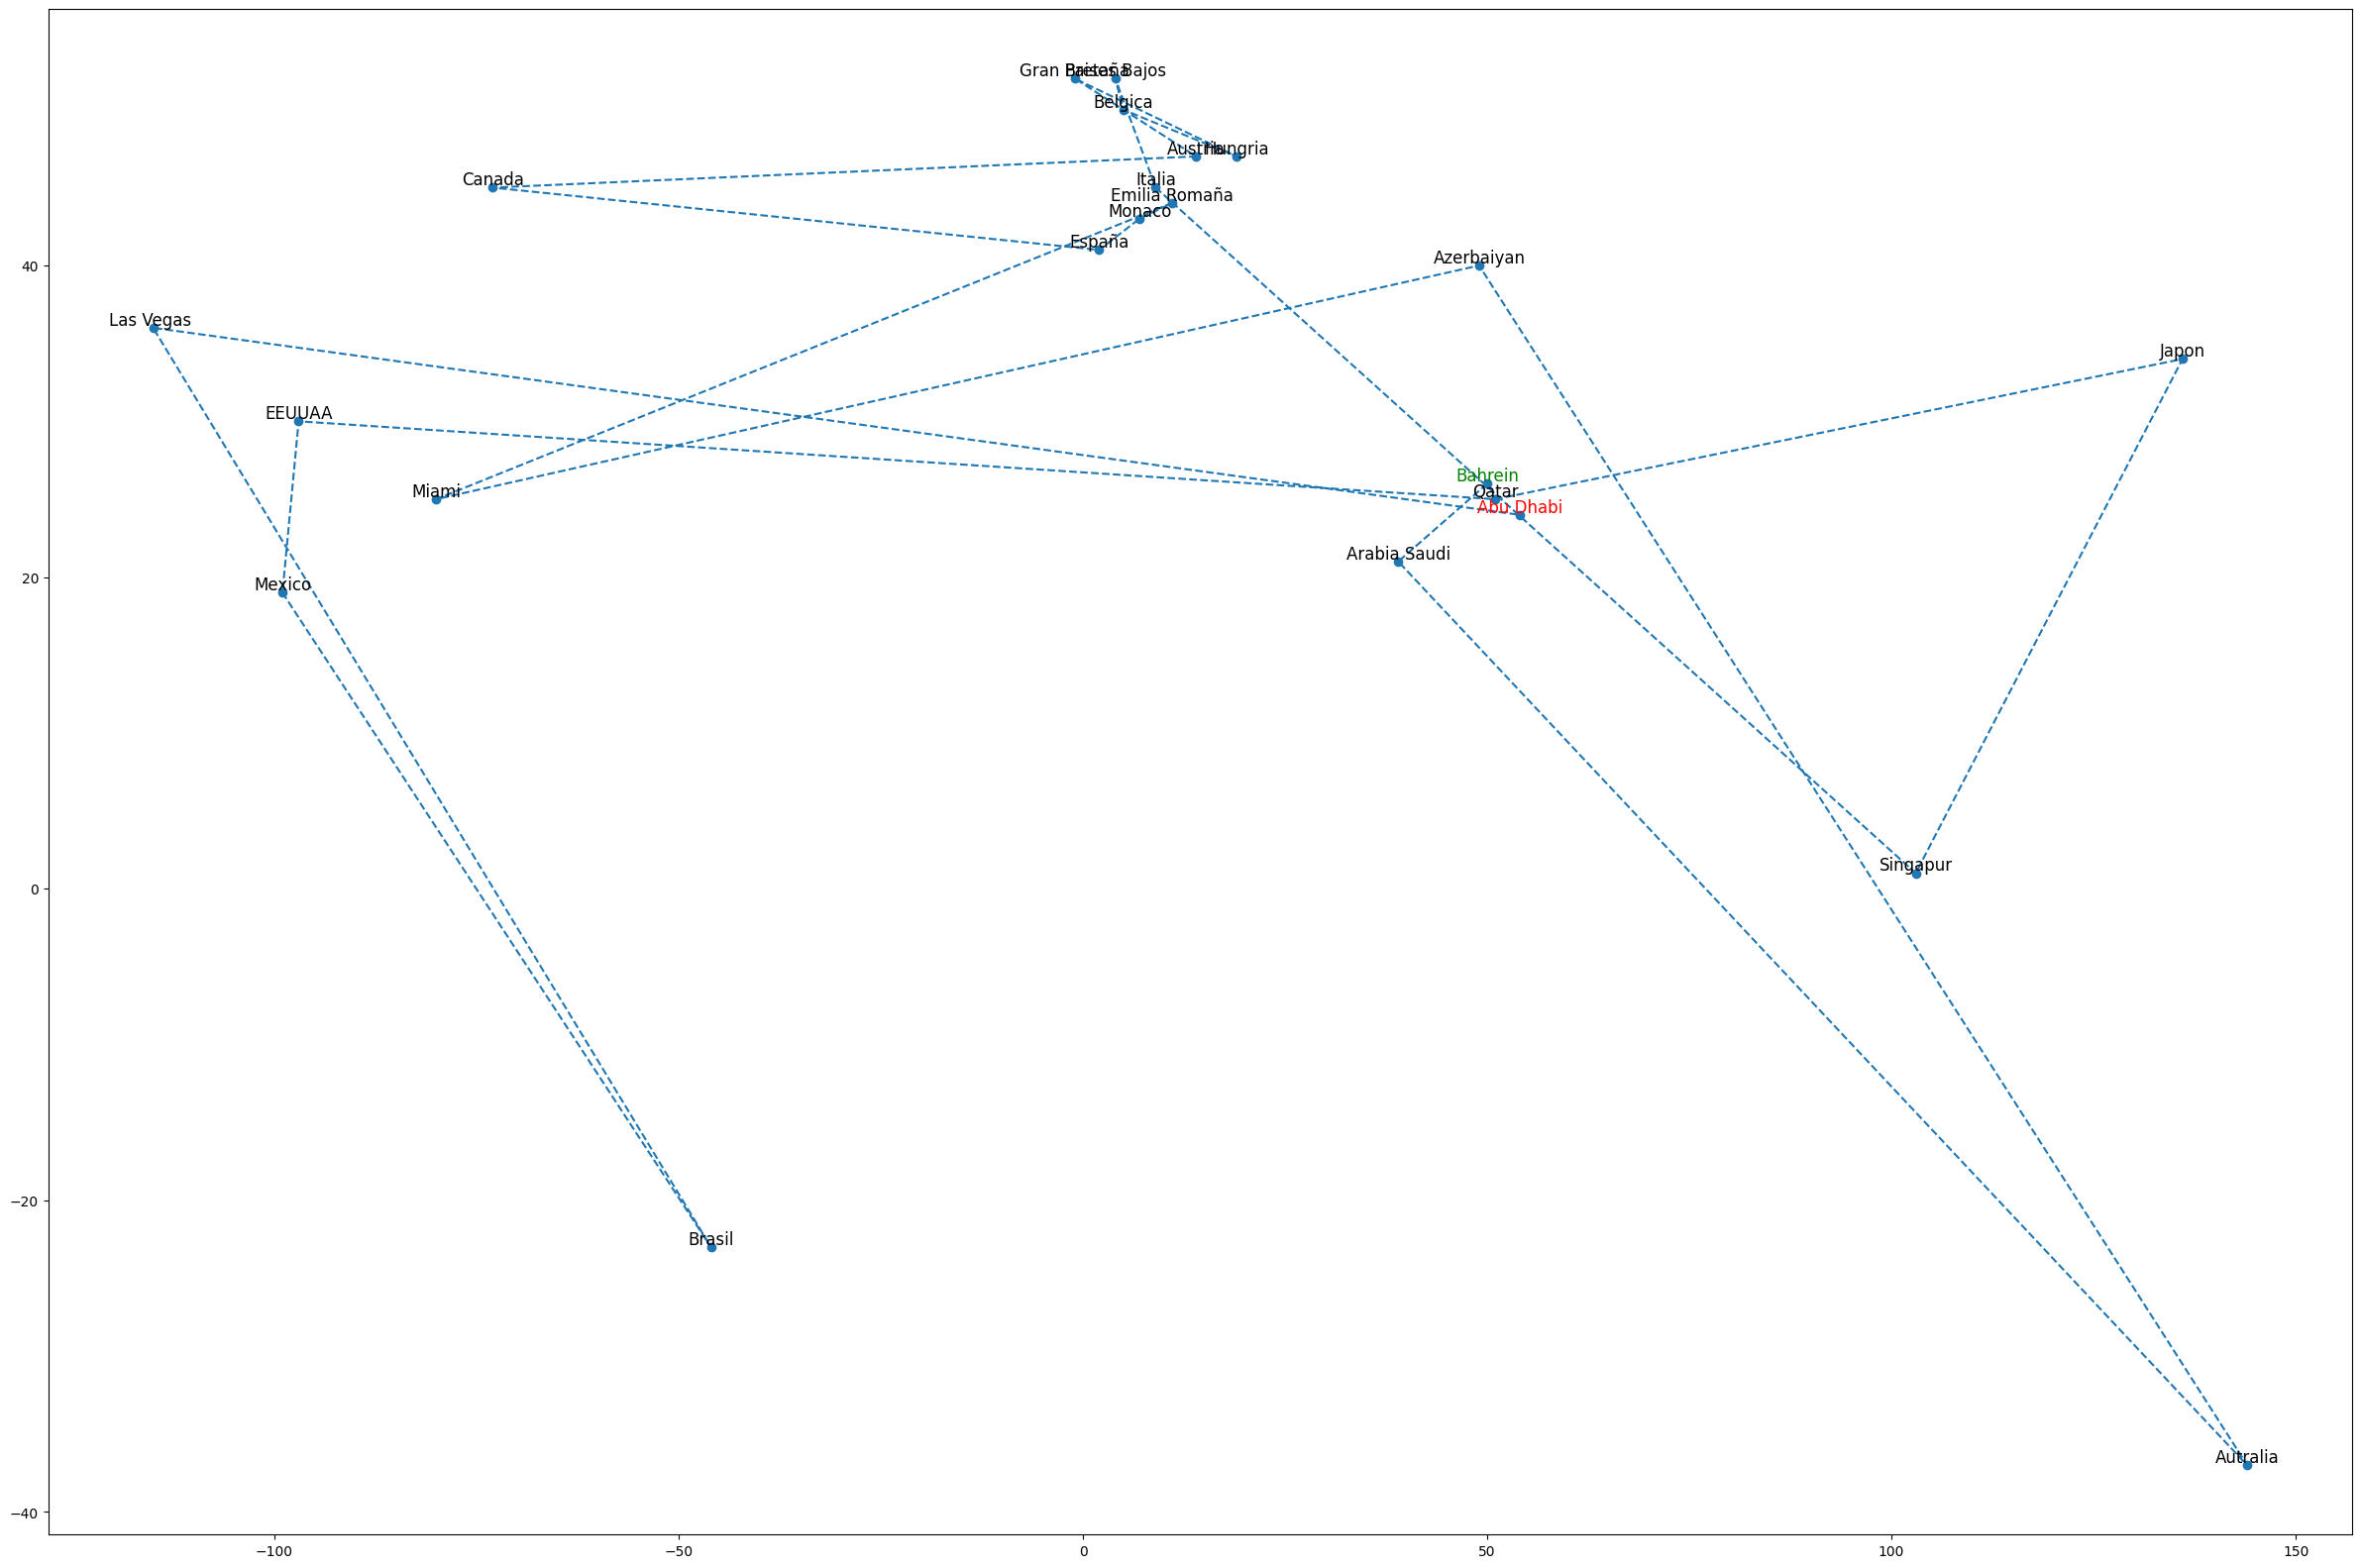

In [760]:


dist=calcular_distancia_total(df)

print(f"distancia total: ", dist)
plot_gp(df)





representacion de los nodos

In [761]:
class Nodo:
    def __init__(self, x, y, fecha, gp):
        self.gp = gp
        self.x = x
        self.y = y
        self.fecha = fecha
        

    def __repr__(self):
        return f"Nodo(x={self.x}, y={self.y}, fecha={self.fecha.date()}, gp={self.gp})"
    

funciones utilitarias para nodos <br>
crear nodos

In [762]:
def crear_nodos(df):
    df['fecha'] = pd.to_datetime(df['fecha'])    
    nodos = [Nodo(row['x'], row['y'], row['fecha'], row['gp']) for index, row in df.iterrows()]   
    return nodos

formula de la distancia euclidiana

In [763]:
def euclidean_distance(nodo1, nodo2):
    return np.sqrt((nodo1.x - nodo2.x)**2 + (nodo1.y - nodo2.y)**2) * 100


cálculo total

In [764]:
def total_distance(nodos):
    distance = 0
    for idx in range(len(nodos) - 1):
        distance += euclidean_distance(nodos[idx], nodos[idx + 1])
    return distance


cambio de dos elementos

In [765]:
def swap_elements(nodos):
    nodos_new = nodos[:]
    swap_list_indx = range(0, len(nodos))

    excluidos = [i for i, nodo in enumerate(nodos_new) if nodo.gp in ['Bahrein', 'Abu Dhabi', 'Monaco']] #fechas excluidas
    swap_list_indx = [idx for idx in swap_list_indx if idx not in excluidos]

    i = random.choice(swap_list_indx)
    j = random.choice(swap_list_indx)


    fecha_i = nodos_new[i].fecha
    fecha_j = nodos_new[j].fecha #mantener las fechas

    nodos_new[i], nodos_new[j] = Nodo(nodos_new[j].x, nodos_new[j].y, fecha_i, nodos_new[j].gp), Nodo(nodos_new[i].x, nodos_new[i].y, fecha_j, nodos_new[i].gp)



    return nodos_new


enfriamiento

In [766]:
def cooling_exp(gamma, temp):
    return gamma * temp

checamos si aceptamos la nueva solucion o no

In [767]:
def check_accept(temp, new_solution, current_solution):
    dif=new_solution - current_solution
    
    prob = min(1, np.exp(-(dif) / temp)) #[0,1]
    if prob > random.uniform(0, 1): #[0,1]
        return True
    else:
        return False

recocido simulado

In [768]:
def temple(iterations, initial_temp, nodos, gamma):
    distancias = []
    best_nodos = nodos.copy()

    current = total_distance(nodos)
    best = total_distance(nodos)
    

    for _ in range(iterations):
        
        nodos_new = swap_elements(nodos) #cambio de dos ciudades     
        new = total_distance(nodos_new)#calcular la nueva distancia
        distancias.append(new)
        

       
        if new < best: #aceptar si es mejor la nueva configuracion
            best_nodos = nodos_new.copy()
            best = new

            
        if check_accept(initial_temp, new, current): #aceptar la nueva configuracion con cierta prob
            nodos = nodos_new.copy()
            current = new

         
        initial_temp = cooling_exp(gamma, initial_temp) #actualizar la temperatura

    return  best_nodos, distancias


/tmp/ipykernel_5665/1384607479.py:4: RuntimeWarning: overflow encountered in exp
  prob = min(1, np.exp(-(dif) / temp)) #[0,1]


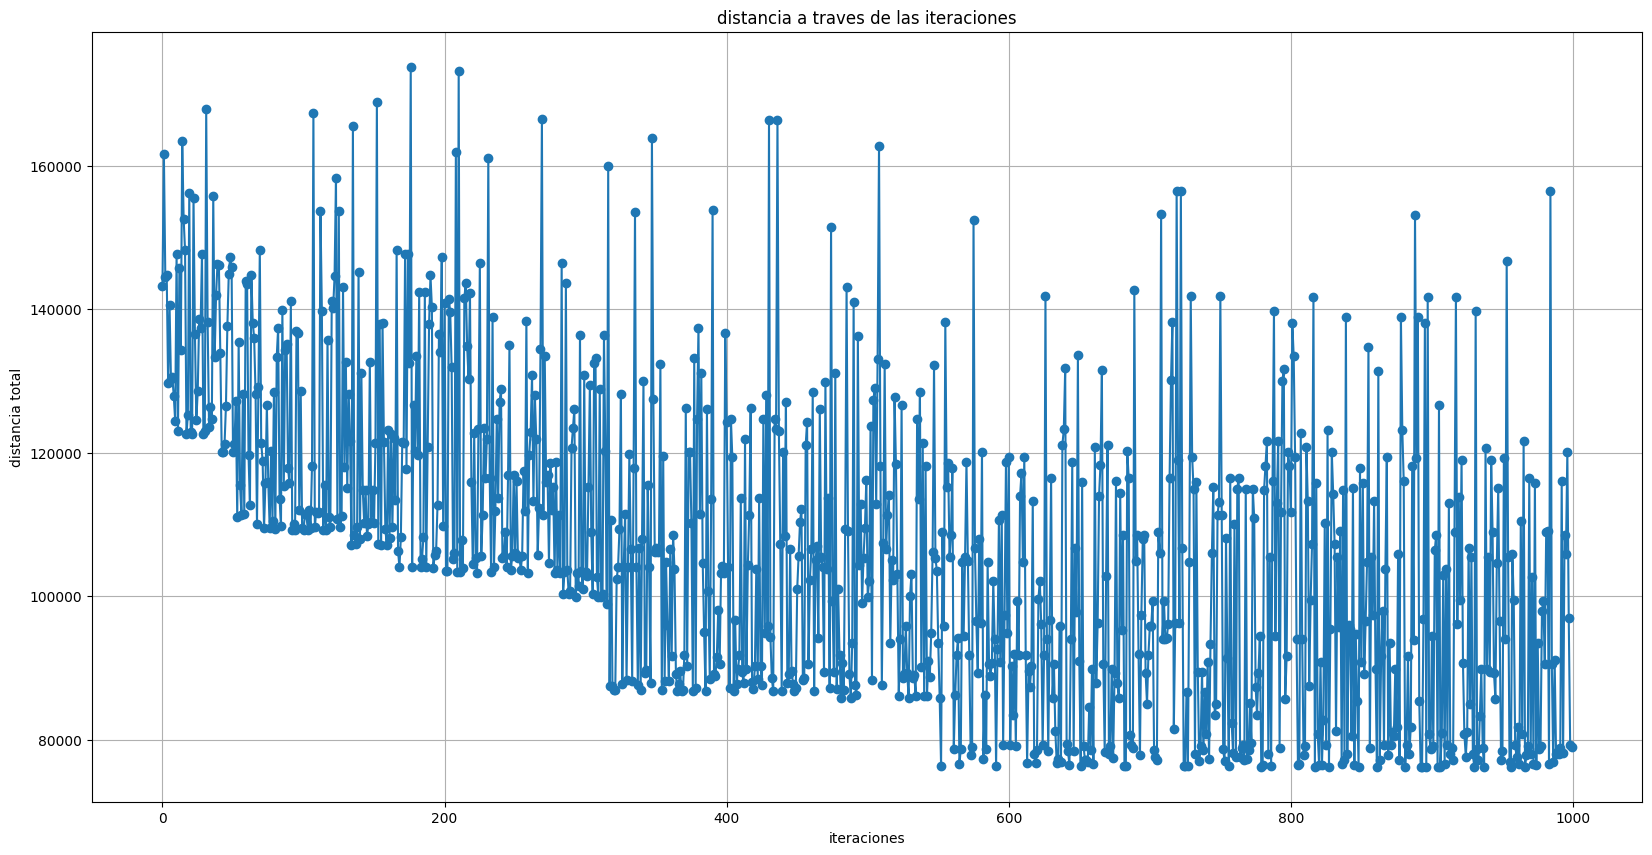

In [769]:
#poniendo a prueba
nodos = crear_nodos(df) #configuracion base


iters=1000
temp=100
gamma=0.90

best_nodos, distancias=temple(iters, temp, nodos, gamma)

df_best_nodos=pd.DataFrame(best_nodos) #convertimos la lista de mejores nodos a una df



#
plt.figure(figsize=(20, 10))
plt.plot(distancias, marker='o', linestyle='-')
plt.title("distancia a traves de las iteraciones")
plt.xlabel("iteraciones")           #como se ven las distancias con el paso del tiempo
plt.ylabel("distancia total")
plt.grid(True)
plt.show()




In [770]:
to_xlsx(df_best_nodos, "ruta_nueva.xlsx") #pasamos el df de mejores nodos a xlsx

archivo guardado:  ruta_nueva.xlsx


In [771]:
df_new = pd.read_excel("ruta_nueva.xlsx") #leemos el nuevo excel
df_new.head(23)

,gp,x,y,fecha
0,Bahrein,50,26,2024-03-03
1,Qatar,51,25,2024-03-17
2,Japon,136,34,2024-03-31
3,Autralia,144,-37,2024-04-28
4,Singapur,103,1,2024-05-05
5,Arabia Saudi,39,21,2024-05-19
6,Monaco,7,43,2024-05-26
7,Italia,9,45,2024-06-02
8,Emilia Romaña,11,44,2024-06-16
9,Azerbaiyan,49,40,2024-06-30


distancia de la nueva ruta:  76229.88753043264


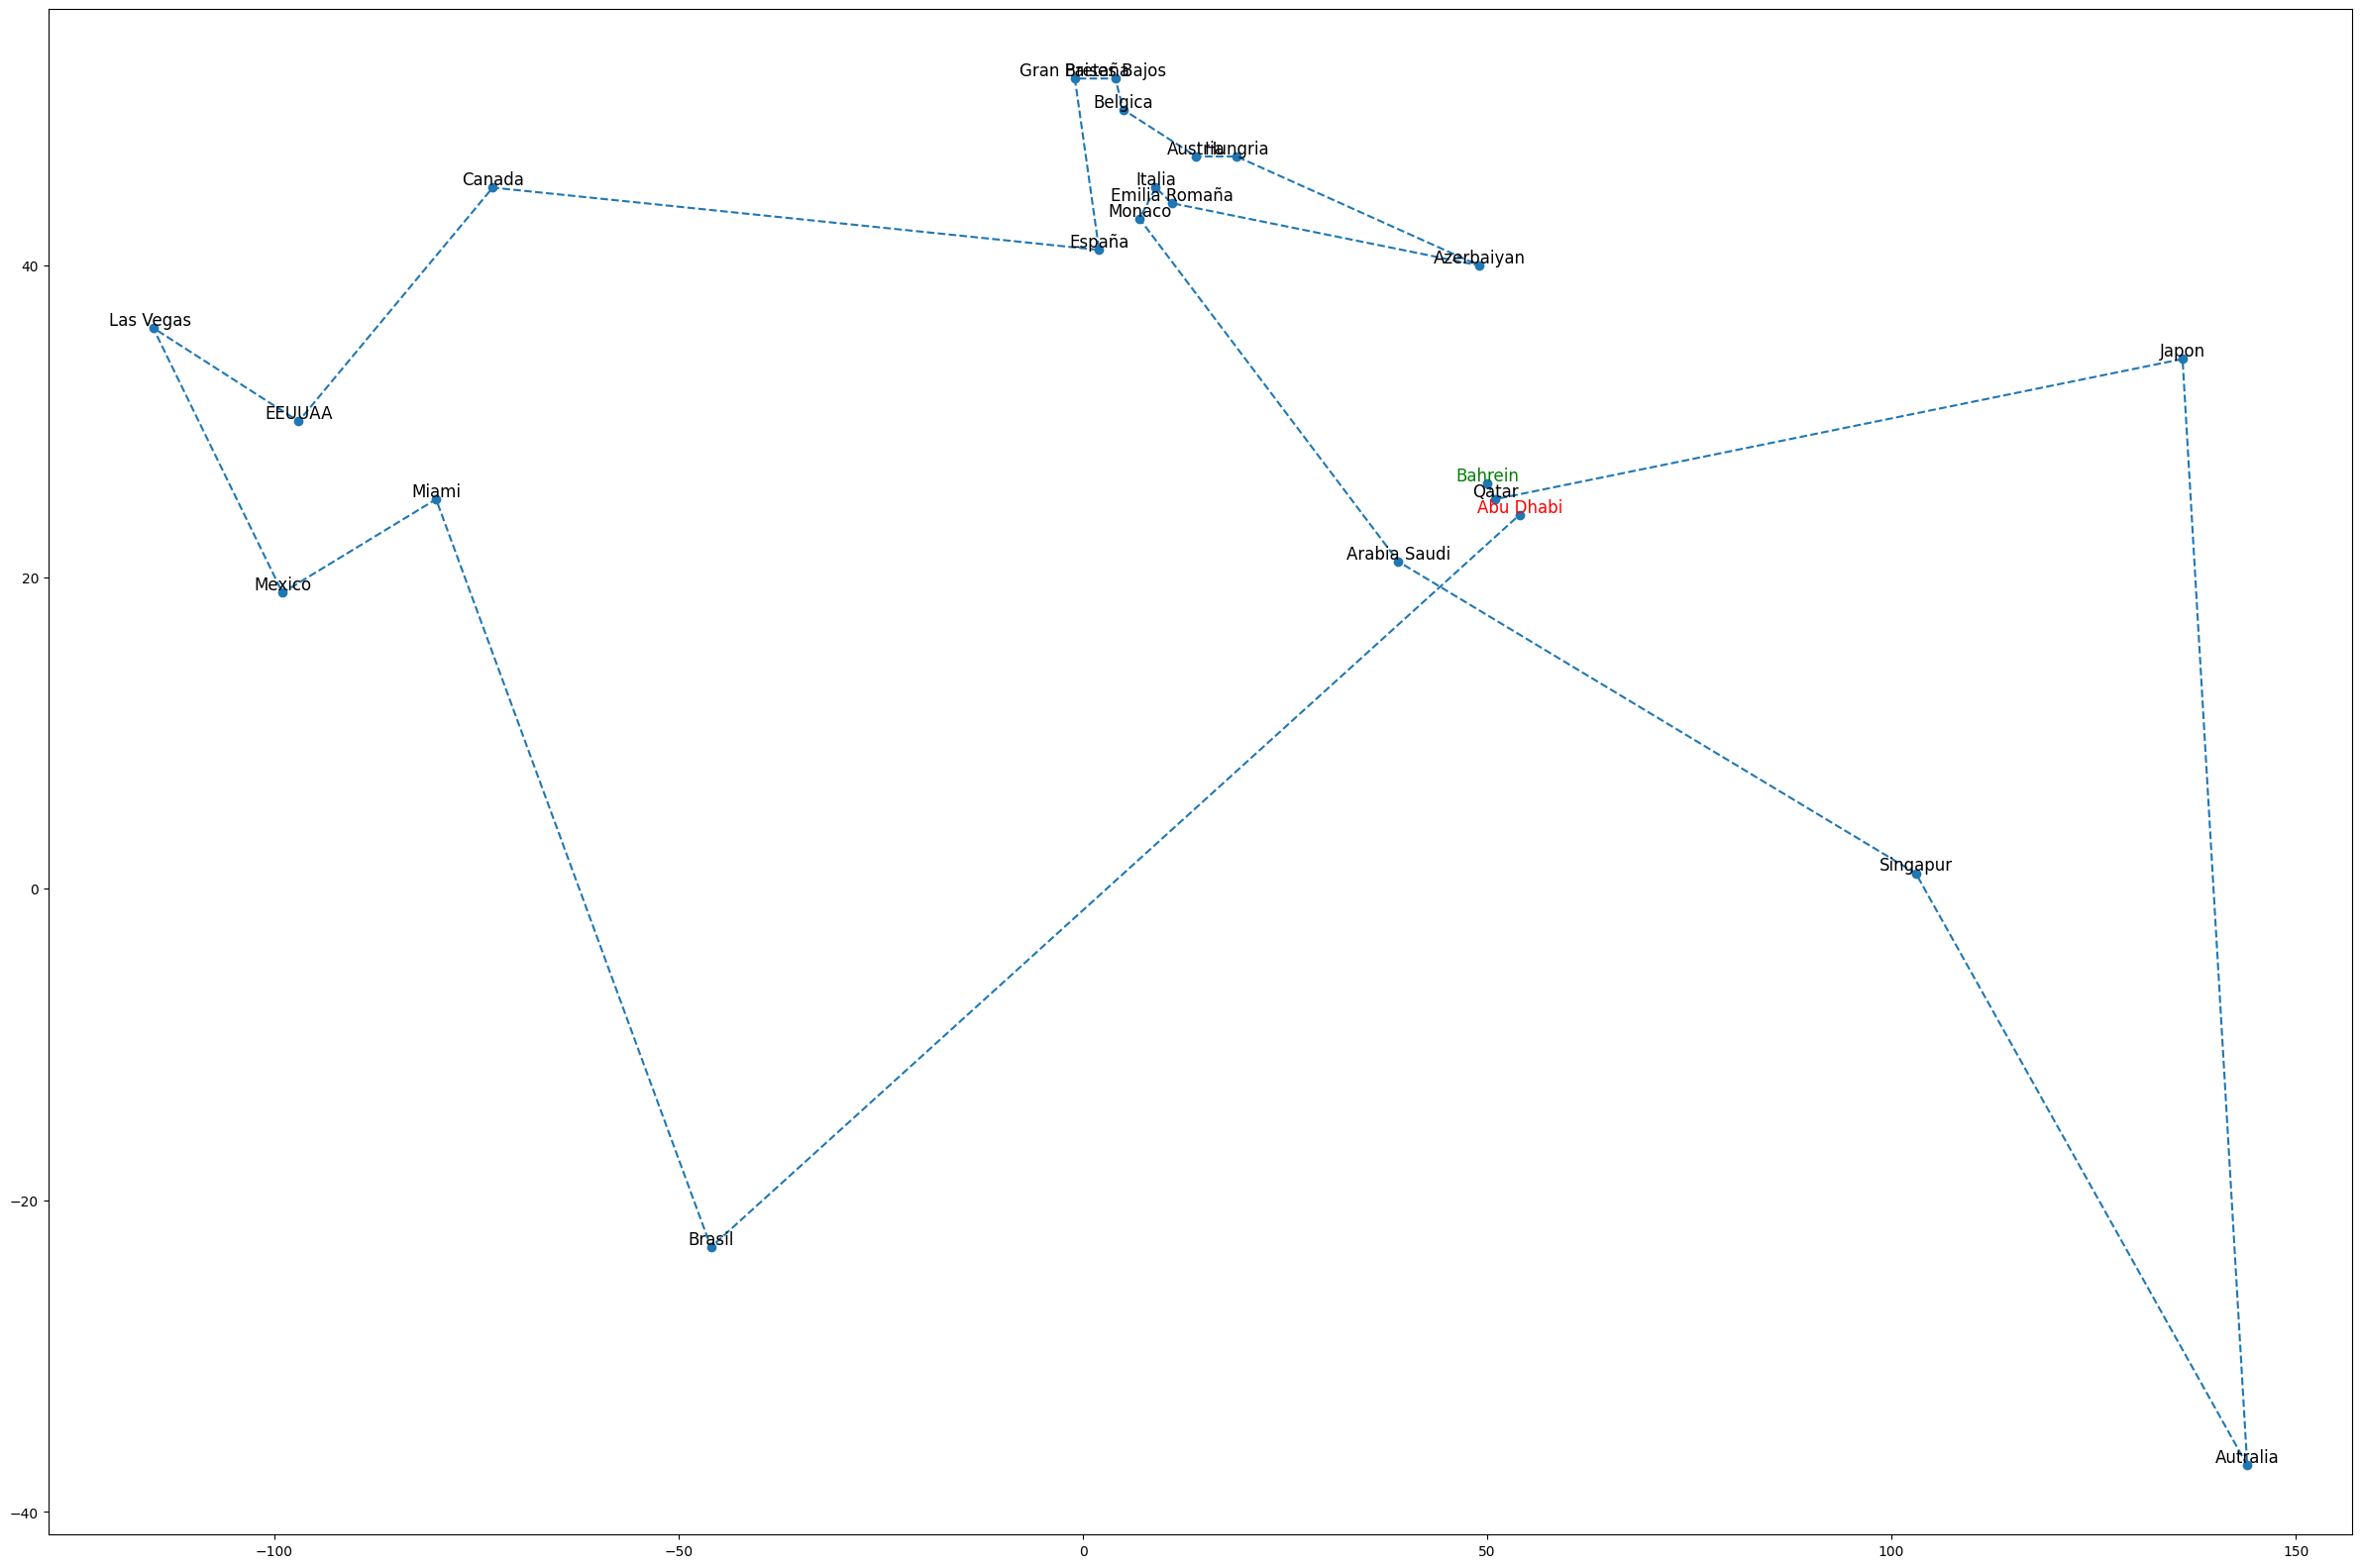

In [772]:
new_dist=calcular_distancia_total(df_new)
print(f"distancia de la nueva ruta: ", new_dist)

plot_gp(df_new)